In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

In [2]:
from nltk.tokenize.casual import TweetTokenizer as TToken
tokenizer = TToken(strip_handles=True, reduce_len=True)

from nltk.corpus import stopwords
s=set(stopwords.words('english'))

from nltk.probability import FreqDist

**Abstract:**
    In this notebook we will explore a data set of tweets about Apple computers over the course of 24 hours. We are interested in discerning whether there is a difference between tweets that were liked or retweeted and those that were not. If there is a discernable difference, we will attempt to create a model that can predict whether a tweet was interacted with from data within the set.

**Cleaning:**
First we load and clean the data, adding in a column for polarity (the relative positivity or negativity of the post), subjectivity (how factual the post is), and Interaction (1 if the post was liked or retweeted, 0 otherwise.

In [3]:
df = pd.read_csv("export_dashboard_apple_2016_04_29_11_14_17.csv")

df = df[df['Tweet language (ISO 639-1)'] == 'en']

df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url
0,725975413462163000,42489,0.381944,kiko,YungKeeks21,??The Land of Enchantment? ?BYU. I used to pun...,RT @DILLONFRANCIS: Dude @CalvinHarris fucking ...,NaN,131.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/7259290195...,557.0,221.0,1.0,en,http://www.twitter.com/YungKeeks21/status/7259...
1,725975412141084000,42489,0.381944,get high-class item,high_item,NaN,Apple iPod classic 7th Generation Black (160 G...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/7201085111...,9.0,40.0,3.0,en,http://www.twitter.com/high_item/status/725975...
3,725975411839107000,42489,0.381944,Gaigko Youklu,Gaigko__Youklu,"Music,sports,photografy,travel,shopping,internet",Apple iPhone 6 - 16GB - Gold (Sprint) Clean Se...,NaN,NaN,53.95800,-1.08300,GB,"New York, USA",http://pbs.twimg.com/profile_images/7127102402...,107.0,NaN,1661.0,en,http://www.twitter.com/Gaigko__Youklu/status/7...
6,725975409955753000,42489,0.381944,C S YEO,gtcsyeo,NaN,Get Jokey Smurfs brand smurfin new hut to play...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/3788000001...,9.0,44.0,NaN,en,http://www.twitter.com/gtcsyeo/status/72597540...
8,725975407267295000,42489,0.381250,MOViN925OnAir,MOViN925OnAir,NaN,Enjoy listening to I Knew You Were Trouble? Bu...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/3614786954...,301.0,1.0,68.0,en,http://www.twitter.com/MOViN925OnAir/status/72...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170474,725617329569173000,42488,0.393750,iH?ppyguy,Eddy_Happyguy,Happiness is my way of life,RT @Roleyy_: Only apple users dey enjoy snapch...,NaN,29.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/7250980650...,3871.0,1557.0,19.0,en,http://www.twitter.com/Eddy_Happyguy/status/72...
170476,725617325618028000,42488,0.393750,muudy f. baby,WhatchoFLAVA,A lose canon that only obeys Murphy's law\n\n\...,RT @2D_Swank: @hplusali about to have your shi...,NaN,1.0,43.70011,-79.41630,CA,Toronto,http://pbs.twimg.com/profile_images/7248212013...,217.0,184.0,1.0,en,http://www.twitter.com/WhatchoFLAVA/status/725...
170477,725617324439527000,42488,0.393750,DigitalArena.co,digitalarenaco,"The Best source of current ideas and news on ,...",RT @Voovwo__Ciudru: NEW APPLE IPAD MINI CASE C...,NaN,1.0,51.50900,-0.12600,GB,London,http://pbs.twimg.com/profile_images/5147172469...,12501.0,13761.0,515.0,en,http://www.twitter.com/digitalarenaco/status/7...
170479,725617323244138000,42488,0.393750,B W D,RT_Bloggers,We retweet! Mention @RT_Bloggers for a retweet.,RT @Glamour_Zine: Flashback! : Techie Gift Gui...,NaN,1.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5534817855...,10011.0,2249.0,738.0,en,http://www.twitter.com/RT_Bloggers/status/7256...


In [4]:
# label the rows baed on interactions
df.loc[df['RTs'] > 0, 'Interaction'] = 1
df.loc[df['Favs'] > 0, 'Interaction'] = 1
df.loc[df['Interaction'].isna(), 'Interaction'] = 0


In [5]:
import re
# removes all numbers, urls, hashtags, handles, symbols, "rt" and new lines from the text
def cleanText(allText):
    allText = allText.lower()
    allText = re.sub(r"http\S+", "", allText)
    allText = re.sub(r"#\S+", "", allText)
    allText = re.sub(r"\w*\d\w*", "", allText)
    allText = re.sub(r"[-!$%^&*()_+|~=`{}\[\]:\";'<>?,.\/]", "", allText)
    allText = re.sub('\n', '', allText)
    allText = re.sub(r"@\w*", '', allText)
    allText = re.sub(r"rt", '', allText)
    return allText

# Define a tokenizer for later
def cleanAndTokenizeText(allText):
    allText = cleanText(allText)
    tokens = tokenizer.tokenize(allText)
    return tokens

In [6]:
with_interaction = df.loc[df['Interaction'] == 1]['Tweet content']
with_interaction = " ".join(with_interaction.array)
with_interaction = cleanText(with_interaction)

In [7]:
without_interaction = df.loc[df['Interaction'] == 0]['Tweet content']

without_interaction = " ".join(without_interaction.array)
without_interaction = cleanText(without_interaction)

In [8]:
interaction_array = [with_interaction, without_interaction]

In [9]:
clean_data = pd.DataFrame(interaction_array)
clean_data['Interaction'] = ['yes', 'no']

clean_data.to_pickle("corpus.pkl")

In [10]:
clean_data

,0,Interaction
0,dude fucking amazing my is added to my ...,yes
1,apple ipod classic generation black gb ap...,no


Now, we clean the full dataset.

In [11]:
df['Cleaned content'] = df['Tweet content'].apply(lambda x: cleanText(x))

In [12]:
df['Cleaned content']

0                                    dude  fucking amazing 
1               apple ipod classic  generation black  gb   
3         apple iphone     gold sprint clean serial numb...
6         get jokey smurfs brand smurfin new hut to play...
8         enjoy listening to i knew you were trouble buy...
                                ...                        
170474      only apple users dey enjoy snapchat android ...
170476       about to have your shit blow up lol apple d...
170477      new apple ipad mini case coverscreen protect...
170479      flashback  techie gift guide for her and him...
170481                  like an apple hanging from a tree  
Name: Cleaned content, Length: 118355, dtype: object

**Sentiment Analysis:**

Now we will determine possible places where the data may differ.To do this we first check for large difference in sentiment to determine if there is a correlation betweet plolarity, subjectivity and whether or not the post was interacted with.

In [13]:
# finding the polarity and subjectivity of each tweet
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['Cleaned content'].apply(pol)
df['subjectivity'] = df['Cleaned content'].apply(sub)
df

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,...,Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Interaction,Cleaned content,polarity,subjectivity
0,725975413462163000,42489,0.381944,kiko,YungKeeks21,??The Land of Enchantment? ?BYU. I used to pun...,RT @DILLONFRANCIS: Dude @CalvinHarris fucking ...,NaN,131.0,NaN,...,http://pbs.twimg.com/profile_images/7259290195...,557.0,221.0,1.0,en,http://www.twitter.com/YungKeeks21/status/7259...,1.0,dude fucking amazing,0.600000,0.900000
1,725975412141084000,42489,0.381944,get high-class item,high_item,NaN,Apple iPod classic 7th Generation Black (160 G...,NaN,NaN,NaN,...,http://pbs.twimg.com/profile_images/7201085111...,9.0,40.0,3.0,en,http://www.twitter.com/high_item/status/725975...,0.0,apple ipod classic generation black gb,0.000000,0.300000
3,725975411839107000,42489,0.381944,Gaigko Youklu,Gaigko__Youklu,"Music,sports,photografy,travel,shopping,internet",Apple iPhone 6 - 16GB - Gold (Sprint) Clean Se...,NaN,NaN,53.95800,...,http://pbs.twimg.com/profile_images/7127102402...,107.0,NaN,1661.0,en,http://www.twitter.com/Gaigko__Youklu/status/7...,0.0,apple iphone gold sprint clean serial numb...,0.366667,0.700000
6,725975409955753000,42489,0.381944,C S YEO,gtcsyeo,NaN,Get Jokey Smurfs brand smurfin new hut to play...,NaN,NaN,NaN,...,http://pbs.twimg.com/profile_images/3788000001...,9.0,44.0,NaN,en,http://www.twitter.com/gtcsyeo/status/72597540...,0.0,get jokey smurfs brand smurfin new hut to play...,-0.131818,0.427273
8,725975407267295000,42489,0.381250,MOViN925OnAir,MOViN925OnAir,NaN,Enjoy listening to I Knew You Were Trouble? Bu...,NaN,NaN,NaN,...,http://pbs.twimg.com/profile_images/3614786954...,301.0,1.0,68.0,en,http://www.twitter.com/MOViN925OnAir/status/72...,0.0,enjoy listening to i knew you were trouble buy...,0.161905,0.411905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170474,725617329569173000,42488,0.393750,iH?ppyguy,Eddy_Happyguy,Happiness is my way of life,RT @Roleyy_: Only apple users dey enjoy snapch...,NaN,29.0,NaN,...,http://pbs.twimg.com/profile_images/7250980650...,3871.0,1557.0,19.0,en,http://www.twitter.com/Eddy_Happyguy/status/72...,1.0,only apple users dey enjoy snapchat android ...,0.250000,0.716667
170476,725617325618028000,42488,0.393750,muudy f. baby,WhatchoFLAVA,A lose canon that only obeys Murphy's law\n\n\...,RT @2D_Swank: @hplusali about to have your shi...,NaN,1.0,43.70011,...,http://pbs.twimg.com/profile_images/7248212013...,217.0,184.0,1.0,en,http://www.twitter.com/WhatchoFLAVA/status/725...,1.0,about to have your shit blow up lol apple d...,0.016667,0.672222
170477,725617324439527000,42488,0.393750,DigitalArena.co,digitalarenaco,"The Best source of current ideas and news on ,...",RT @Voovwo__Ciudru: NEW APPLE IPAD MINI CASE C...,NaN,1.0,51.50900,...,http://pbs.twimg.com/profile_images/5147172469...,12501.0,13761.0,515.0,en,http://www.twitter.com/digitalarenaco/status/7...,1.0,new apple ipad mini case coverscreen protect...,0.018182,0.377273
170479,725617323244138000,42488,0.393750,B W D,RT_Bloggers,We retweet! Mention @RT_Bloggers for a retweet.,RT @Glamour_Zine: Flashback! : Techie Gift Gui...,NaN,1.0,NaN,...,http://pbs.twimg.com/profile_images/5534817855...,10011.0,2249.0,738.0,en,http://www.twitter.com/RT_Bloggers/status/7256...,1.0,flashback techie gift guide for her and him...,0.000000,0.000000


In [14]:
df.to_pickle('full_data_clean_and_polarized_round1.pkl')

In [15]:
# average polarity of tweets with interaction
df.loc[df['Interaction'] == 1]['polarity'].mean()

0.11749622379063777

In [16]:
# standard deviation of polarity of tweets with interaction
df.loc[df['Interaction'] == 1]['polarity'].std()

0.24547952910316112

In [17]:
# average polarity of tweets without interaction
df.loc[df['Interaction'] == 0]['polarity'].mean()

0.08517628015216404

In [18]:
# standard deviation of polarity of tweets without interaction
df.loc[df['Interaction'] == 0]['polarity'].std()

0.25861264320993405

In [19]:
# average subjectivity of tweets with interaction
df.loc[df['Interaction'] == 1]['subjectivity'].mean()

0.32077272198268086

In [20]:
# standard deviation of subjectivity of tweets with interaction
df.loc[df['Interaction'] == 1]['subjectivity'].std()

0.3142458790002386

In [21]:
# average subjectivity of tweets without interaction
df.loc[df['Interaction'] == 0]['subjectivity'].mean()

0.35273944727321

In [24]:
# standard deviation of subjectivity of tweets without interaction
df.loc[df['Interaction'] == 0]['subjectivity'].std()

0.3477325179496292

There doesn't appear to be a significant difference between the sentiments of tweets that have interaction and those that don't.

To further explore, we graph the data.

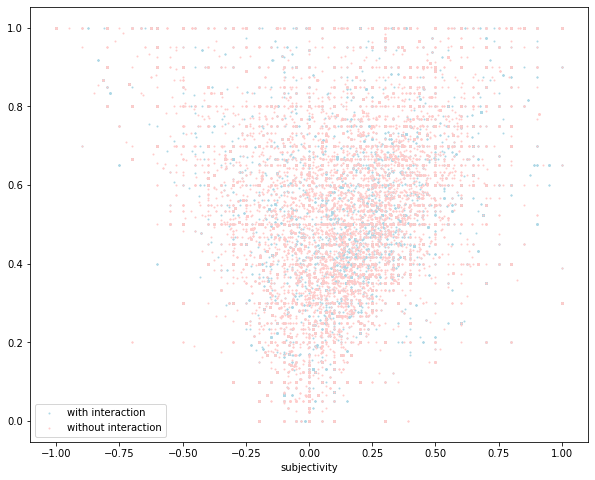

In [23]:
import matplotlib.pyplot as plt

def plot_sentiment():
    fig, ax = plt.subplots()
    ax.scatter(df.loc[df['Interaction'] == 1]['polarity'], df.loc[df['Interaction'] == 1]['subjectivity'], label="with interaction", c="#add8e6", s=1)
    ax.scatter(df.loc[df['Interaction'] == 0]['polarity'], df.loc[df['Interaction'] == 0]['subjectivity'], label="without interaction", c="#ffcccb", s=1)
    plt.xlabel("polarity")
    plt.xlabel("subjectivity")
    # plt.xlim(-1.5,1.5)
    # plt.ylim(-1.5,1.5)
    fig.set_size_inches(10, 8, forward=True)
    ax.legend()
    plt.show()
    
plot_sentiment()

As expected, the data all hangs out around the same area.

This could be due to overlap in the words which are present in both sets, so, we will filter out the words which are most common in both sections of the data.

We will explore further in tweet-topc-analysis.ipynb 